In [14]:
import torch
print('version :' , torch.__version__)
print('cuda :' , torch.cuda.is_available())
print('cudnn :' , torch.backends.cudnn.enabled)
!pip install gputil
import GPUtil
GPUtil.showUtilization()
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
if torch.cuda.is_available(): torch.cuda.manual_seed(230)

version : 1.0.0
cuda : True
cudnn : True
| ID | GPU | MEM |
------------------
|  0 |  3% | 16% |


In [27]:
import random
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
print(torch.cuda.synchronize())

None


In [28]:
BATCH = 32
EPOCH = 10

In [29]:
class SIGNSDataset(Dataset):
    """
    A standard PyTorch definition of Dataset which defines the functions __len__ and __getitem__.
    """
    def __init__(self, data_dir, transform):
        """
        Store the filenames of the jpgs to use. Specifies transforms to apply on images.
        Args:
            data_dir: (string) directory containing the dataset
            transform: (torchvision.transforms) transformation to apply on image
        """
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]

        self.labels = [int(os.path.split(filename)[-1][0]) for filename in self.filenames]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        """
        Fetch index idx image and labels from dataset. Perform transforms on image.
        Args:
            idx: (int) index in [0, 1, ..., size_of_dataset-1]
        Returns:
            image: (Tensor) transformed image
            label: (int) corresponding label of image
        """
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [30]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.ToTensor()])  # transform it into a torch tensor

# loader for evaluation, no horizontal flip
eval_transformer = transforms.Compose([
    transforms.Resize(64),  # resize the image to 64x64 (remove if images are already 64x64)
    transforms.ToTensor()])  # transform it into a torch tensor

train_data_path = "dataset/train_signs/"
test_data_path = "dataset/SIGNS dataset/test_signs/"
val_data_path = "dataset/SIGNS dataset/test_signs/"

traindata = SIGNSDataset(train_data_path, train_transformer)
testdata = SIGNSDataset(test_data_path, eval_transformer)

#shuffle 打亂順序
train_dataloader = DataLoader(traindata, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(testdata, batch_size=BATCH, shuffle=False)
torch.cuda.manual_seed(230)

<class 'int'>
(3, 64, 64)
(64, 64, 3)


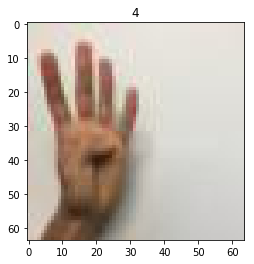

<class 'int'>
(3, 64, 64)
(64, 64, 3)


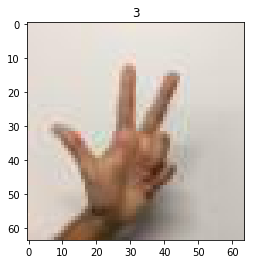

<class 'int'>
(3, 64, 64)
(64, 64, 3)


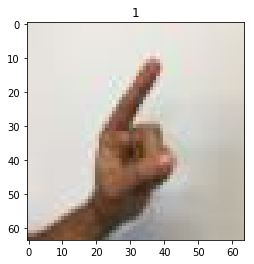

In [31]:
for i in range(3):
    img,lab = train_dataloader.dataset[i]
    img = np.asarray(img)
    print(type(lab))
    print(img.shape)
    img = img.transpose((1, 2, 0))
    print(img.shape)
    plt.imshow(img, cmap='gray')
    plt.title('%i' % lab)
    plt.show()

In [32]:
class InceptionA(nn.Module):
    def __init__(self,in_channels):
        super(InceptionA, self).__init__()
        self.conv1 = nn.Sequential(       # input  (3,_,_)
            nn.AvgPool2d(3,1,1),          # output  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
        )
        self.conv2 = nn.Sequential(       # input  (3,_,_)
            nn.MaxPool2d(3,1,1),          # output  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
        )
        
        self.conv3 = nn.Sequential(       # input  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
            nn.Conv2d(16,16,5,1,2),       # output  (16,_,_)
        )
        
        self.conv4 = nn.Sequential(       # input  (3,_,_)
            nn.Conv2d(in_channels,8,1),   # output  (8,_,_)
            #nn.Conv2d(16,24,3,1,1),      # output  (24,_,_)
            nn.Conv2d(8,16,3,1,1),        # output  (16,_,_)
        )
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        
        outputs = [x2,x3,x4,x1]
        #outputs = [x3,x4,x1]#72
        
        return torch.cat(outputs,1)       # output  (16*4, 32, 32)<<
                                          # output  (88, 32, 32)<<
####################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(       # input  (3, 32, 32)
            nn.Conv2d(3,20,5,1,2),        # output  (20, 32, 32)
            InceptionA(in_channels=20),   # output  (64, 32, 32)
            nn.MaxPool2d(2),              # output  (64, 16, 16)
        )
        self.conv2 = nn.Sequential(       # input  (64, 16, 16)
            nn.Conv2d(64,40,5,1,2),       # output  (40, 16, 16)
            InceptionA(in_channels=40),   # output  (64, 16, 16)
            nn.MaxPool2d(2),              # output  (64, 8, 8)
        )
        
        self.out1 = nn.Linear(64*16*16, 1024) #fully connected layer
        self.out2 = nn.Linear(1024, 128)
        self.out3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = x.view(x.size(0), -1)
        x = self.out1(x)
        x = self.out2(x)
        x = self.out3(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x    # return x for visualization

In [33]:
class Net(nn.Module):
    """
    This is the standard way to define your own network in PyTorch. You typically choose the components
    (e.g. LSTMs, linear layers etc.) of your network in the __init__ function. You then apply these layers
    on the input step-by-step in the forward function. You can use torch.nn.functional to apply functions
    such as F.relu, F.sigmoid, F.softmax, F.max_pool2d. Be careful to ensure your dimensions are correct after each
    step. You are encouraged to have a look at the network in pytorch/nlp/model/net.py to get a better sense of how
    you can go about defining your own network.
    The documentation for all the various components available o you is here: http://pytorch.org/docs/master/nn.html
    """

    def __init__(self):

        super(Net, self).__init__()
        self.num_channels = 32
        
        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.
        # For more details on how to use these layers, check out the documentation.
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)       
        self.dropout_rate = 0.8

    def forward(self, s):
        """
        This function defines how we use the components of our network to operate on an input batch.
        Args:
            s: (Variable) contains a batch of images, of dimension batch_size x 3 x 64 x 64 .
        Returns:
            out: (Variable) dimension batch_size x 6 with the log probabilities for the labels of each image.
        Note: the dimensions after each step are provided
        """
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.bn1(self.conv1(s))                         # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.bn2(self.conv2(s))                         # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.bn3(self.conv3(s))                         # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.dropout(F.relu(self.fcbn1(self.fc1(s))), 
            p=self.dropout_rate, training=self.training)    # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)


In [34]:
if torch.cuda.is_available():
    cnn = CNN().cuda()
    print("Run in GPU")
else:
    cnn = CNN()
print(cnn)

Run in GPU
CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InceptionA(
      (conv1): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=1, padding=1)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv2): Sequential(
        (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Sequential(
        (0): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (conv4): Sequential(
        (0): Conv2d(20, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 40, kernel_size=(5, 5), stride=(1,

In [35]:
if torch.cuda.is_available():
    Cnn = Net().cuda()
    print("Run in GPU")
else:
    Cnn = Net()
print(Cnn)

Run in GPU
Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fcbn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [36]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()    

In [37]:
def train(epoch):
    for step, (x, y) in enumerate(train_dataloader):
        data, target = x.cuda(async=True), y.cuda(async=True)
        data = Variable(data)   # batch x
        target = Variable(target)   # batch y

        output = Cnn(data)               # cnn output
        #loss = nn.functional.nll_loss(output, target)
        loss = loss_func(output, target)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
           step * len(data), len(train_dataloader.dataset),100. * step / len(train_dataloader), loss.data.item()))
    print("Finish")
    GPUtil.showUtilization()

In [38]:
for epoch in range(1,EPOCH):
    if epoch== 1:
        ts = time.time()
    train(epoch)
te = time.time()
print("Total cost %f sec" % (te - ts))

NameError: name 'time' is not defined